In [1]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
sys.path.insert(0, "../src/")


In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'

# This is the largest possible value of the logloss
logloss_inf_limit = -np.log(np.finfo('float').eps) 


In [3]:
# Define result path

# adaptive var
res_path = osp.join('..', 'output', 'real_data_20200804_110806', 'results.csv')
res_df = pd.read_csv(res_path)
print(res_df.columns)
res_df.head()

Index(['dataset_name', 'trainset_size', 'trail_num', 'valset_size',
       'testset_size', 'num_features', 'time', 'mn_test_mse', 'mn_theta_norm',
       'mn_test_logloss', 'mn_variance', 'genie_test_logloss',
       'genie_test_mse', 'genie_theta_norm', 'empirical_pnml_regret',
       'empirical_pnml_test_logloss', 'analytical_pnml_regret',
       'analytical_pnml_test_logloss', 'analytical_pnml_isit_regret',
       'analytical_pnml_isit_test_logloss', 'mdl_lambda_opt', 'mdl_test_mse',
       'mdl_theta_norm', 'mdl_test_logloss', 'mdl_variance', 'test_idx'],
      dtype='object')


,dataset_name,trainset_size,trail_num,valset_size,testset_size,num_features,time,mn_test_mse,mn_theta_norm,mn_test_logloss,...,analytical_pnml_regret,analytical_pnml_test_logloss,analytical_pnml_isit_regret,analytical_pnml_isit_test_logloss,mdl_lambda_opt,mdl_test_mse,mdl_theta_norm,mdl_test_logloss,mdl_variance,test_idx
0,645_fri_c3_500_50,3,0,100,100,51,0.039333,0.326887,0.176912,1.042459,...,0.833875,1.693646,0.080384,0.940156,[224.78168757],0.417946,0.033959,1.098196,0.899143,0
1,645_fri_c3_500_50,3,0,100,100,51,0.039333,0.976912,0.176912,1.409795,...,0.833564,1.728239,0.184196,1.078870,[224.78168757],1.012113,0.033959,1.428603,0.899143,1
2,645_fri_c3_500_50,3,0,100,100,51,0.039333,1.032990,0.176912,1.441485,...,0.846677,1.735793,0.032336,0.921451,[224.78168757],1.240778,0.033959,1.555760,0.899143,2
3,645_fri_c3_500_50,3,0,100,100,51,0.039333,0.546166,0.176912,1.166376,...,0.815048,1.679238,0.020279,0.884468,[224.78168757],0.538224,0.033959,1.165080,0.899143,3
4,645_fri_c3_500_50,3,0,100,100,51,0.039333,0.828516,0.176912,1.325935,...,0.825436,1.694763,0.121387,0.990714,[224.78168757],0.297445,0.033959,1.031187,0.899143,4


In [8]:
# Choose specific configurations
dataset_name = '645_fri_c3_500_50'
trainset_size = 3
trail_num = 0
df = res_df[(res_df['dataset_name'] == dataset_name) & \
            (res_df['trainset_size'] == trainset_size) &\
            (res_df['trail_num'] == trail_num)
           ]

In [9]:
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()

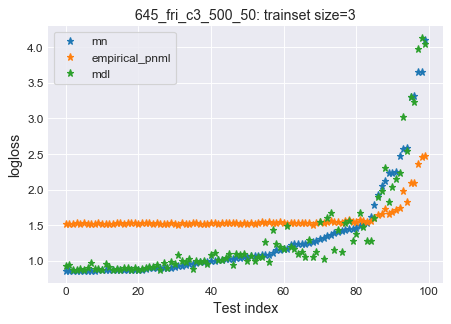

In [14]:
plt.plot(df_sorted['mn_test_logloss'],'*', label='mn')
plt.plot(df_sorted['empirical_pnml_test_logloss'],'*', label='empirical_pnml')
plt.plot(df_sorted['mdl_test_logloss'],'*', label='mdl')
plt.legend()
plt.title('{}: trainset size={}'.format(dataset_name,trainset_size))
plt.xlabel('Test index')
plt.ylabel('logloss')
# plt.xscale('log')
plt.show()